In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

learning_rate = 0.1
training_epochs = 5000
display_step = 100
n_idle_epochs = 1000
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=n_idle_epochs, min_delta=0.00001)

def scheduler(epoch, lr):
    if lr <= 0.01:
        return lr
    if epoch % 200 == 0:
        return lr * 0.8
    else:
        return lr
reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

class NEPOCHLogger(tf.keras.callbacks.Callback):
    def __init__(self, per_epoch=100):
        super(NEPOCHLogger, self).__init__()
        self.seen = 0
        self.per_epoch = per_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.per_epoch == 0:
            print('Epoch {}, loss {:.8f}, accuracy {:.8f}'.format(epoch, logs['loss'], logs['acc']))

log_display = NEPOCHLogger(per_epoch=display_step)
train_data = pd.read_csv(r'two_spiral_train_data.txt', header=None, sep='\s+')
test_data = pd.read_csv(r'two_spiral_test_data.txt', header=None, sep='\s+')
train_data['class_0'] = train_data[2].apply(lambda x: 1 if x == 0 else 0)
train_data['class_1'] = train_data[2].apply(lambda x: 1 if x == 1 else 0)
test_data['class_0'] = test_data[2].apply(lambda x: 1 if x == 0 else 0)
test_data['class_1'] = test_data[2].apply(lambda x: 1 if x == 1 else 0)

train_X = tf.convert_to_tensor(np.asarray(train_data.iloc[:, 0:2]))
train_y = tf.convert_to_tensor(np.asarray(train_data.iloc[:, 2]))
test_X = tf.convert_to_tensor(np.asarray(test_data.iloc[:, 0:2]))
test_y = tf.convert_to_tensor(np.asarray(test_data.iloc[:, 2]))

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, input_shape=(2,), activation='swish'),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

optimizer = tf.keras.optimizers.SGD(learning_rate)
# tf.keras.losses
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [14]:
history = model.fit(train_X, train_y, epochs=training_epochs, verbose=0, batch_size=16, callbacks=[log_display, reduce_lr])
print("Train Finished!", history)

# print('Final train loss: %10.8f' % history.history["loss"][-1])
# print('Final test loss: %10.8f' % model.evaluate(test_X, test_y, verbose=0)[0])
y_hat_train = model.predict(train_X, verbose=0)
y_hat_test = model.predict(test_X, verbose=0)
# abs_train_error = np.abs((tf.convert_to_tensor(np.reshape(y_hat_train, (300,2))) - tf.cast(train_y, tf.float32)).numpy())
# abs_test_error = np.abs((tf.convert_to_tensor(np.reshape(y_hat_test, (300,2))) - tf.cast(test_y, tf.float32)).numpy())
print('total number of test samples: %d' % len(test_y))
# print('number of train samples with absolute error >= 0.1: %d' % len(abs_train_error[abs_train_error >= 0.10]))
# print('number of train samples with absolute error >= 0.5: %d' % len(abs_train_error[abs_train_error >= 0.50]))
# print('number of test samples with absolute error >= 0.1: %d' % len(abs_test_error[abs_test_error >= 0.10]))
# print('number of test samples with absolute error >= 0.5: %d' % len(abs_test_error[abs_test_error >= 0.50]))
print(model.evaluate(test_X, test_y, verbose=0))
# with open('abs_test_error.txt', 'w') as f:
#     for item in abs_test_error:
#         f.write("%s\n" % item)

Epoch 0, loss 0.65269977, accuracy 0.53333336
Epoch 100, loss 0.65243596, accuracy 0.53333336
Epoch 200, loss 0.65263247, accuracy 0.54333335
Epoch 300, loss 0.65240198, accuracy 0.52999997
Epoch 400, loss 0.65236807, accuracy 0.53333336
Epoch 500, loss 0.65197444, accuracy 0.52999997
Epoch 600, loss 0.65200680, accuracy 0.51999998
Epoch 700, loss 0.65191925, accuracy 0.52333331
Epoch 800, loss 0.65152079, accuracy 0.51999998
Epoch 900, loss 0.65181750, accuracy 0.51666665
Epoch 1000, loss 0.65171152, accuracy 0.53666669
Epoch 1100, loss 0.65182674, accuracy 0.52999997
Epoch 1200, loss 0.65159172, accuracy 0.52333331
Epoch 1300, loss 0.65138543, accuracy 0.51666665
Epoch 1400, loss 0.65144849, accuracy 0.52666664
Epoch 1500, loss 0.65123957, accuracy 0.52666664
Epoch 1600, loss 0.65150702, accuracy 0.52333331
Epoch 1700, loss 0.65114546, accuracy 0.51666665
Epoch 1800, loss 0.65114290, accuracy 0.52999997
Epoch 1900, loss 0.65088087, accuracy 0.52999997
Epoch 2000, loss 0.65083331, acc

In [12]:
class_0_area, class_1_area = {}, {}
for x in np.arange(-10, 10, 0.2):
    for y in np.arange(-10, 10, 0.2):
        if model.predict([[x, y]], verbose=0)[0][0] > 0.5:
            class_1_area.setdefault('x', []).append(x)
            class_1_area.setdefault('y', []).append(y)
        else:
            class_0_area.setdefault('x', []).append(x)
            class_0_area.setdefault('y', []).append(y)

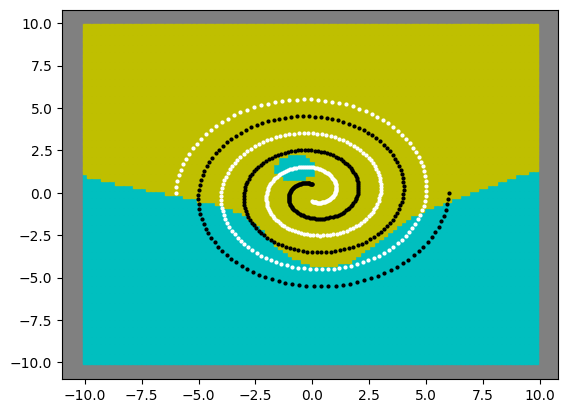

In [13]:
class_0, class_1 = {}, {}
for X, y in zip(np.concatenate([train_X.numpy(), test_X.numpy()], 0), np.concatenate([train_y.numpy(), test_y.numpy()], 0)):
    if y == 0:
        class_0.setdefault('x', []).append(X[0])
        class_0.setdefault('y', []).append(X[1])
    else:
        class_1.setdefault('x', []).append(X[0])
        class_1.setdefault('y', []).append(X[1])
plt.axes().set_facecolor('gray')
plt.plot(class_0_area['x'], class_0_area['y'], 'cs', markersize=3, label='class 0 area')
plt.plot(class_1_area['x'], class_1_area['y'], 'ys', markersize=3, label='class 1 area')
plt.plot(class_0['x'], class_0['y'], 'wo', markersize=2, label='class 0')
plt.plot(class_1['x'], class_1['y'], 'o', markersize=2, color='#000000', label='class 1')
plt.show()